# Vague d'impulsion

In [1]:
from pathlib import Path
from config import config
from insert_dam import insert_dam
from makeqinit_matplotlib import make_qinit
from make_tools import make_new, make_output, make_data
from energy import compute_energies_masses, plot as plot_energy_mass

import topo_utils

import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import LightSource

from clawpack.geoclaw import fgout_tools
from clawpack.geoclaw import fgmax_tools
from clawpack.geoclaw import topotools

## Loading DEM

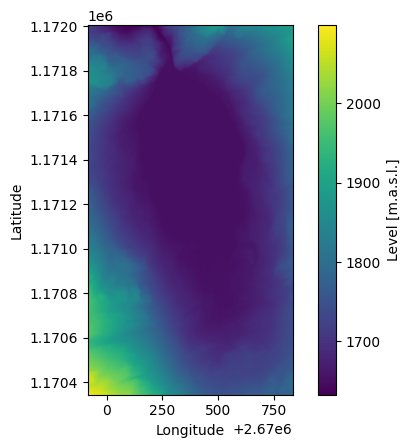

In [2]:
bbox = config["lower"]+config["upper"]
w, s, e, n = bbox
extent = w, e, s, n
x, y, Z = topo_utils.read_raster(config["base_bathymetry"],
                                 bbox,
                                 config["cell_size"])

plt.imshow(Z, extent=extent)
plt.colorbar(label="Level [m.a.s.l.]")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

## Hillshade

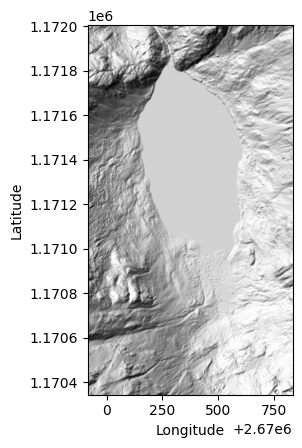

In [3]:
ls = LightSource(azdeg=315, altdeg=45)
plt.imshow(ls.hillshade(Z), cmap="gray", extent=extent)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

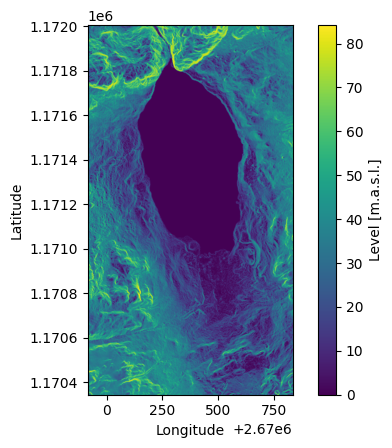

In [4]:
slope = np.sqrt(np.square(np.gradient(Z, config["cell_size"])).sum(axis=0))
slope = np.rad2deg(np.arctan(slope))
plt.imshow(slope, extent=extent)
plt.colorbar(label="Level [m.a.s.l.]")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

## AVAC

Reading fgout grid info from 
    ../avac_trift/_output/fgout_grids.data
Reading input for fgno=2, point_style = 2 
Found fgout grid q_out_vars =  [1, 2, 3, 4]
Using this mapping to fgout variable names: 
      qmap =  {'h': 1, 'hu': 2, 'hv': 3, 'eta': 4, 'B': 5}
    Reading  Frame 1 at t = 0  from outdir = /home/giboul/Desktop/avac_trift/_output
    Reading  Frame 90 at t = 90  from outdir = /home/giboul/Desktop/avac_trift/_output


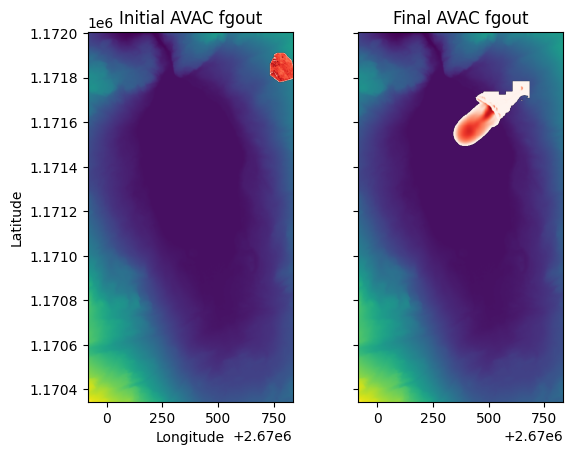

In [5]:
avac_fgout = fgout_tools.FGoutGrid(config["fgout_fgno"], config["AVAC_outdir"])
avac_fgout.read_fgout_grids_data()

avac_hinit = avac_fgout.read_frame(1).h
avac_hfinal = avac_fgout.read_frame(avac_fgout.nout).h

avac_hinit = np.where(avac_hinit>0, avac_hinit, np.nan)
avac_hfinal = np.where(avac_hfinal>0, avac_hfinal, np.nan)

fig, axes = plt.subplots(ncols=2, sharex="all", sharey="all")
for ax in axes:
    ax.imshow(Z, extent=extent)

avac_fgout.extent = avac_fgout.x1, avac_fgout.x2, avac_fgout.y1, avac_fgout.y2
axes[1].imshow(avac_hfinal.T, extent=avac_fgout.extent, origin="lower", cmap="Reds")
axes[0].imshow(avac_hinit.T, extent=avac_fgout.extent, origin="lower", cmap="Reds")

axes[0].set_xlabel("Longitude")
axes[0].set_ylabel("Latitude")

axes[0].set_title("Initial AVAC fgout")
axes[1].set_title("Final AVAC fgout")

for ax in axes:
    ax.set_xlim(extent[:2])
    ax.set_ylim(extent[2:])
plt.show()

## Insert dam

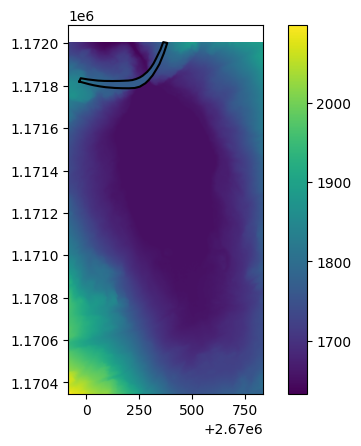

In [6]:
dams = topo_utils.read_poly(config["dams"])
Z = insert_dam(dams, config["dam_alts"], x, y, Z)
plt.imshow(Z, extent=extent)
plt.plot(*dams[0].T, c="k")
plt.colorbar()
plt.show()

## Initial solution (lake) and initially fine regions

In [7]:
flood_seed = 2.67e6 + 400, 1.1712e6
x0, y0, eta0, qinit_extent = make_qinit(x, y, Z,
                                  config["lake_alt"],
                                  flood_seed=flood_seed,
                                  dilation_radius=config["flood_dilation"])
np.savetxt("qinit.extent", qinit_extent)

Filling lake


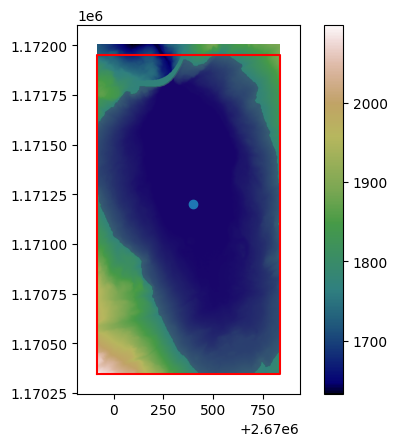

In [8]:
regions = [np.loadtxt(region_file) for region_file in Path().glob("qinit*.extent")]

extent0 = x0.min(), x0.max(), y0.min(), y0.max()
plt.imshow(Z, extent=extent, cmap="gist_earth")
plt.colorbar()
plt.imshow(np.where(eta0>Z.min(), eta0, np.nan), extent=extent0, alpha=0.3)
plt.scatter(*flood_seed)

for region in regions:
    w, e, s, n = region
    plt.plot([w, e, e, w, w], [s, s, n, n, s], c="r")
plt.xlim(np.array([-100, 100])+plt.xlim())
plt.ylim(np.array([-100, 100])+plt.ylim())
plt.show()

## Exporting the DEMs for geoclaw

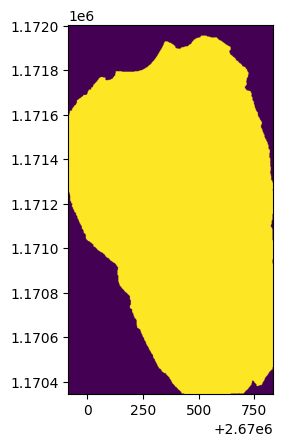

In [9]:
topo = topotools.Topography()
topo.x = x0
topo.y = y0[::-1]
topo.Z = eta0[::-1, :]
topo.write(config["qinit"][0], topo_type=1)  # There can be multiple qinit files

topo = topotools.Topography(config["qinit"][0])
plt.imshow(topo.Z, extent=(topo.x.min(), topo.x.max(), topo.y.min(), topo.y.max()), origin="lower")
plt.show()

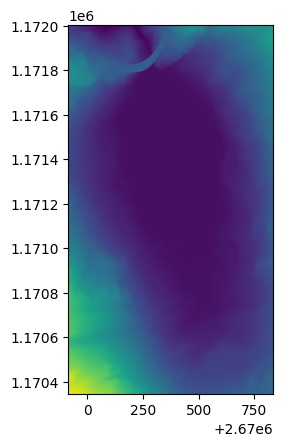

In [10]:
topo = topotools.Topography()
topo.x = x
topo.y = y[::-1]  # TODO
topo.Z = Z[::-1, :]
topo.write(config["bathymetry"], topo_type=config["topo_type"])

topo = topotools.Topography(config["bathymetry"])
plt.imshow(topo.Z, extent=(topo.x.min(), topo.x.max(), topo.y.min(), topo.y.max()), origin="lower")
plt.show()

## Make executable, data & output

In [11]:
if not Path("xgeoclaw").is_file():
    exit_code = make_new()
    assert exit_code ==1, "Compilation failed! See logs above."

In [12]:
exit_code = make_data(AVAC_outdir=config["AVAC_outdir"], outdir="_output")
exit_code = make_output(OUTDIR="_output")

Makefile:71: warning: overriding recipe for target 'all'
/home/giboul/.venvs/claw/src/clawpack/clawutil/src/Makefile.common:323: warning: ignoring old recipe for target 'all'
Makefile:78: warning: overriding recipe for target 'data'
/home/giboul/.venvs/claw/src/clawpack/clawutil/src/Makefile.common:230: warning: ignoring old recipe for target 'data'


rm -f .data
python setrun.py         geoclaw                   
Reading fgout grid info from 
    /home/giboul/Desktop/TriftGeoClaw/../avac_trift/_output/fgout_grids.data
Reading input for fgno=1, point_style = 2 
Found fgout grid q_out_vars =  [1, 2, 3, 4]
Using this mapping to fgout variable names: 
      qmap =  {'h': 1, 'hu': 2, 'hv': 3, 'eta': 4, 'B': 5}
Coarsest cells size : 131.43, 138.33
Finest cells size : 2.05, 2.16

---------------------------------------------- 
fgout grid 1 has point_style = 2
   specifying fgout grid with shape 940 by 1680, with  1579200 points
   lower left  = (2669905.0000000000,1170335.0000000000)
   upper right = (2670845.0000000000,1172015.0000000000)
   dx = 1.0000000000e+00,  dy = 1.0000000000e+00

---------------------------------------------- 
fgmax grid 1 has point_style = 2
   specifying fixed grid with shape 941 by 1681, with  1581821 points
   lower left  = (2669905.0000000000,1170335.0000000000)
   upper right = (2670845.0000000000,1172015.0

Makefile:71: warning: overriding recipe for target 'all'
/home/giboul/.venvs/claw/src/clawpack/clawutil/src/Makefile.common:323: warning: ignoring old recipe for target 'all'
Makefile:78: warning: overriding recipe for target 'data'
/home/giboul/.venvs/claw/src/clawpack/clawutil/src/Makefile.common:230: warning: ignoring old recipe for target 'data'


rm -f .output
python /home/giboul/.venvs/claw/src/clawpack/clawutil/src/python/clawutil/runclaw.py xgeoclaw                  _output \
True None . False False None 
==> runclaw: Will take data from  /home/giboul/Desktop/TriftGeoClaw
==> runclaw: Will write output to  /home/giboul/Desktop/TriftGeoClaw/_output
==> runclaw: Removing all old fort/gauge files in  /home/giboul/Desktop/TriftGeoClaw/_output

==> Running with command:
    /home/giboul/Desktop/TriftGeoClaw/xgeoclaw
Reading data file: claw.data
         first 5 lines are comments and will be skipped
Reading data file: amr.data
         first 5 lines are comments and will be skipped
  
 Running amrclaw ...  
  
Reading data file: setprob.data
         first 5 lines are comments and will be skipped
Reading data file: /home/giboul/Desktop/TriftGeoClaw/../avac_trift/_output/fgout_grids.data
         first 5 lines are comments and will be skipped
 +++ q_out_vars: T T T T F F
 +++ nqout =            4
 +++ q_out_vars: T T T T F F
 +++ 

## Results (fgmax): maximum values

In [ ]:
fg = fgmax_tools.FGmaxGrid()
fg.outdir = "_output"
fg.read_fgmax_grids_data(1, Path("_output") / "fgmax_grids.data")
fg.read_output()
fg.extent = fg.x1, fg.x2, fg.y1, fg.y2
repr(fg.eta)

Reading input for fgno=1, point_style = 2 
Reading _output/fgmax0001.txt ...


'None'

TypeError: Image data of dtype object cannot be converted to float

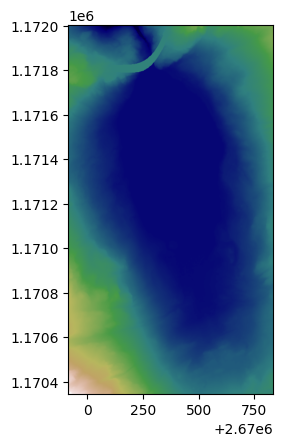

In [ ]:
plt.imshow(Z, extent=extent, cmap="gist_earth")
plt.imshow(np.where(fg.h>0, fg.eta, np.nan).T, extent=fg.extent, origin="lower", cmap="RdBu_r")
plt.colorbar(label=r"Maximum level $\Delta h$ [m]", extend="both")
plt.show()

## Results (fgout)

Reading fgout grid info from 
    _output/fgout_grids.data
Reading input for fgno=1, point_style = 2 
Found fgout grid q_out_vars =  [1, 2, 3, 4]
Using this mapping to fgout variable names: 
      qmap =  {'h': 1, 'hu': 2, 'hv': 3, 'eta': 4, 'B': 5}
    Reading  Frame 1 at t = 0  from outdir = /home/giboul/Desktop/TriftGeoClaw/_output


/tmp/ipykernel_15168/1705698067.py:6: RuntimeWarning: invalid value encountered in divide
  frame_init.V = np.sqrt((frame_init.hu/(1e-10*frame_init.h))**2 + (frame_init.hv/(1e-10*frame_init.h))**2)


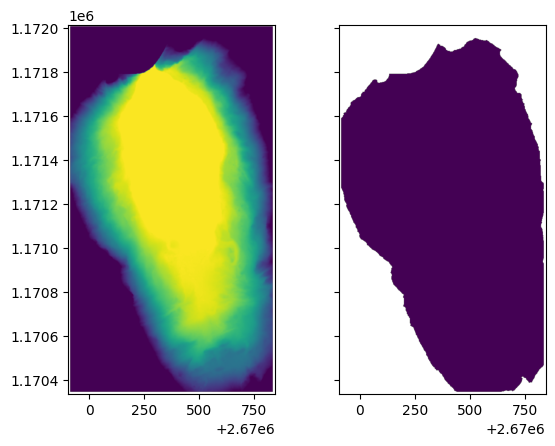

In [ ]:
fgout = fgout_tools.FGoutGrid(1, "_output")
fgout.read_fgout_grids_data()
fgout.extent = fgout.x1, fgout.x2, fgout.y1, fgout.y2

frame_init = fgout.read_frame(1)
frame_init.V = np.sqrt((frame_init.hu/(1e-10+frame_init.h))**2 + (frame_init.hv/(1e-10+frame_init.h))**2)

fig, axes = plt.subplots(ncols=2, sharex="row", sharey="row")
axes[0].imshow(frame_init.h.T, extent=fgout.extent, origin="lower")
axes[1].imshow(frame_init.V.T, extent=fgout.extent, origin="lower")
plt.show()

## Finding maximums (over fgout)

In [ ]:
q_max = np.zeros_like(frame_init.q)
for i in range(1, fgout.nout):
    q_max = np.maximum(q_max, fgout.read_frame(i).q)

hmax = q_max[0]
vmax = np.sqrt((q_max[1]/(1e-10+q_max[0]))**2 + (q_max[2]/(1e-10+q_max[0]))**2)

    Reading  Frame 2 at t = 0.20202  from outdir = /home/giboul/Desktop/TriftGeoClaw/_output
    Reading  Frame 3 at t = 0.40404  from outdir = /home/giboul/Desktop/TriftGeoClaw/_output
    Reading  Frame 4 at t = 0.606061  from outdir = /home/giboul/Desktop/TriftGeoClaw/_output
    Reading  Frame 5 at t = 0.808081  from outdir = /home/giboul/Desktop/TriftGeoClaw/_output
    Reading  Frame 6 at t = 1.0101  from outdir = /home/giboul/Desktop/TriftGeoClaw/_output
    Reading  Frame 7 at t = 1.21212  from outdir = /home/giboul/Desktop/TriftGeoClaw/_output
    Reading  Frame 8 at t = 1.41414  from outdir = /home/giboul/Desktop/TriftGeoClaw/_output
    Reading  Frame 9 at t = 1.61616  from outdir = /home/giboul/Desktop/TriftGeoClaw/_output
    Reading  Frame 10 at t = 1.81818  from outdir = /home/giboul/Desktop/TriftGeoClaw/_output
    Reading  Frame 11 at t = 2.0202  from outdir = /home/giboul/Desktop/TriftGeoClaw/_output
    Reading  Frame 12 at t = 2.22222  from outdir = /home/giboul/Des

/tmp/ipykernel_15168/705692805.py:6: RuntimeWarning: invalid value encountered in divide
  vmax = np.sqrt((q_max[1]/(1e-10*q_max[0]))**2 + (q_max[2]/(1e-10*q_max[0]))**2)


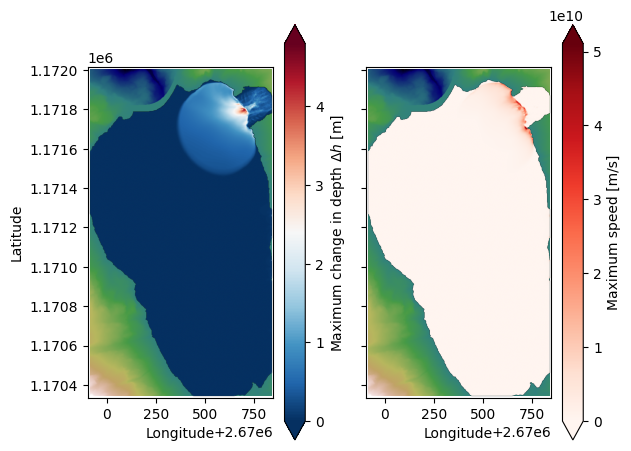

In [ ]:
fig, (axh, axv) = plt.subplots(ncols=2, sharex="all", sharey="all", layout="tight")

for ax in (axh, axv):
    ax.imshow(Z, extent=extent, cmap="gist_earth")
axv.set_xlabel("Longitude")
axh.set_xlabel("Longitude")
axh.set_ylabel("Latitude")

imh = axh.imshow(np.where(hmax>0, hmax-frame_init.h, np.nan).T, extent=fgout.extent, origin="lower", cmap="RdBu_r")
fig.colorbar(imh, ax=axh, location="right", label=r"Maximum change in depth $\Delta h$ [m]", extend="both")

imv = axv.imshow(np.where(hmax>0, vmax, np.nan).T, extent=fgout.extent, origin="lower", cmap="Reds")
fig.colorbar(imv, ax=axv, location="right", label="Maximum speed [m/s]", extend="both")

plt.show()